In [5]:
import numpy as np
from random import randint as rand
from matplotlib import pyplot as plt

In [2]:
import config
config.configure_imports()

from Map import Map
from Node import Node
from Change import Change
from LPAStar import LPAStar
from DStar import DStar
from DStarLite import DStarLite
from a_star import a_star

from visualizer import *
from data_parser import *

In [3]:
lak105d_filename = '../data/lak105d.map'
lak105d_scen_filename = '../data/lak105d.map.scen'
den204d_filename = '../data/den204d.map'
den204d_scen_filename = '../data/den204d.map.scen'
den312d_filename = '../data/den312d.map'
den312d_scen_filename = '../data/den312d.map.scen'

In [4]:
def compare_lpa_a_star(map_filename, scen_filename, n_tasks = None, n_changes = 10):
    lpa_visiteds = []
    a_star_visiteds = []
    for start_i, start_j, goal_i, goal_j, _ in read_map_scen(scen_filename, n_tasks):
        _map, _map_a = Map(), Map()
        _map.read_from_string(*read_map(map_filename))
        _map_a.read_from_string(*read_map(map_filename))

        start = Node(start_i, start_j)
        finish = Node(goal_i, goal_j)

        for _ in range(n_changes):
            true_result, a_star_visited = a_star(_map_a, start, finish, return_visited=True)
            if true_result == -1:
                break

            lpa_star = LPAStar(_map, start, finish)
            lpa_path = lpa_star.greedy_path()

            if len(lpa_path) < 3:
                break


            index = rand(1, len(lpa_path) - 1)
            qi, qj = lpa_path[index].coordinates()

            lpa_visited = lpa_star.apply_changes([Change(0, qi, qj, True)])
            _map_a.apply_change(Change(0, qi, qj, True))

            lpa_visiteds.append(len(lpa_visited))
            a_star_visiteds.append(len(a_star_visited))

    return lpa_visiteds, a_star_visiteds

In [9]:
def draw_lpa_vs_a_star(lpa_v, a_v, title):
    indices = np.array(a_v).argsort()
    lpa_v = np.array(lpa_v)[indices]
    a_v = np.array(a_v)[indices]
    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.scatter(list(range(len(a_v))), lpa_v, label='LPA*')
    ax.scatter(list(range(len(a_v))), a_v, label='A*')
    ax.set_xlabel('test №')
    ax.set_ylabel('open vertices')
    ax.set_title(title)
    ax.legend()
    plt.show()

In [7]:
lpa_lak_v, a_lak_v = compare_lpa_a_star(lak105d_filename, lak105d_scen_filename)

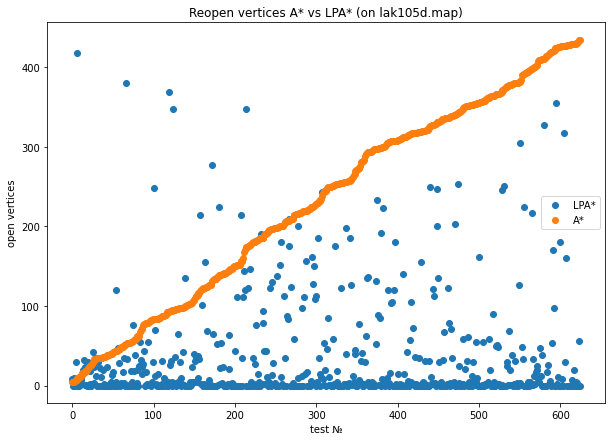

In [11]:
draw_lpa_vs_a_star(lpa_lak_v, a_lak_v, 'Reopen vertices A* vs LPA* (on lak105d.map)')

In [12]:
lpa_den_v, a_den_v = compare_lpa_a_star(den312d_filename, den312d_scen_filename, n_changes=10)

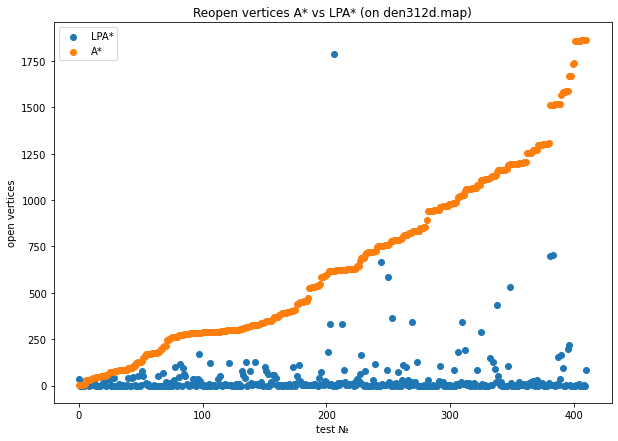

In [13]:
draw_lpa_vs_a_star(lpa_den_v, a_den_v, 'Reopen vertices A* vs LPA* (on den312d.map)')